# Preprocessing

Load DBS all channal data   
Bipolar referencing   
High pass filter    

setting for low and high pass
https://neurodsp-tools.github.io/neurodsp/generated/neurodsp.filt.filter_signal.html 

1. low pass filter at 250 hz
2. high pass filter at 0.1 hz
3. notch filter for line noise
4. downsample to 1000 hz (3 times above the LPF, read the reference https://en.wikipedia.org/wiki/Anti-aliasing_filter)
5. bipolar re-reference from shafts to rings
6. plot power spectrum 

In [1]:
import scipy
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#Analysis
from scipy import signal
from neurodsp.spectral import compute_spectrum
# Pre-processing: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/filt/plot_3_IIR.html?highlight=line%20noise
from neurodsp.filt import filter_signal
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series

In [2]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/fuq01' 
# Specify subject names 
subj_ids = ['701','702','705','814','815']

mat_dict = {f'{x}': [] for x in subj_ids}
elec_dict = {f'{x}': [] for x in subj_ids}

In [3]:
elec_channal = ['CRAW_01', 'CRAW_02', 'CRAW_03', 'CRAW_04', 'CRAW_05', 'CMacro_RAW_01', 'CMacro_RAW_02', 'CMacro_RAW_03']
elec_dic = {'ring 0': 'CLFP1', 'seg 1A': 'CLFP2', 'seg 1B': 'CLFP3', 'seg 1C': 'CLFP4', 'seg 2A': 'CLFP5', 'seg 2B': 'CMacro LFP1', 'seg 2C': 'CMacro LFP1', 'ring 3': 'CMacro LFP3'}

In [4]:
def load_mat(dir_files):
    data_all = []
    for m in dir_files:
        file = scipy.io.loadmat(m)
        data_all.append(file)
    return data_all

In [5]:
sub_dir = f'{base_dir}/Documents/GitHub/leap-analysis/LFP/data/702'
mat_file = load_mat(glob.glob(f'{sub_dir}/*.mat'))
example_data = mat_file[0]

In [6]:
example_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Apr 10 12:09:51 2023',
 '__version__': '1.0',
 '__globals__': [],
 'CLFP_01': array([[-46, -44, -43, ..., -28, -30, -30]], dtype=int16),
 'CLFP_01_KHz': array([[1.375]]),
 'CLFP_01_KHz_Orig': array([[1.375]]),
 'CLFP_01_BitResolution': array([[38.14697266]]),
 'CLFP_01_Gain': array([[20]], dtype=uint8),
 'CLFP_01_TimeBegin': array([[11791.83272727]]),
 'CLFP_01_TimeEnd': array([[11854.328]]),
 'CLFP_02': array([[-45, -43, -42, ...,  26,  25,  25]], dtype=int16),
 'CLFP_02_KHz': array([[1.375]]),
 'CLFP_02_KHz_Orig': array([[1.375]]),
 'CLFP_02_BitResolution': array([[38.14697266]]),
 'CLFP_02_Gain': array([[20]], dtype=uint8),
 'CLFP_02_TimeBegin': array([[11791.83272727]]),
 'CLFP_02_TimeEnd': array([[11854.328]]),
 'CLFP_03': array([[241, 242, 243, ...,  92,  91,  91]], dtype=int16),
 'CLFP_03_KHz': array([[1.375]]),
 'CLFP_03_KHz_Orig': array([[1.375]]),
 'CLFP_03_BitResolution': array([[38.14697266]]),
 'CLFP_

In [101]:
# example signal and original sampling rate 
fs = example_data['CRAW_01_KHz'].flatten()*1000
fs = fs[0].astype(np.float32)
sig = example_data['CRAW_01'].flatten()
c2 = example_data['CRAW_02'].flatten()

In [87]:
def add_buffer(sig, fs, n_seconds=2):
    """Add buffer to the beginning and end of a signal.
    Parameters
    ----------
    sig : 1d array
        Time series.
    fs : float
        Sampling rate, in Hz.
    n_seconds : float
        Buffer, in seconds, to add to the beginning and end of the signal.
    Returns
    -------
    sig_buffer : 1d array
        Time series with buffer.
    """

    n_buffer = int(fs * n_seconds)
    buff_pre = sig[0:n_buffer] # create pre-buffer index
    buff_post = sig[-n_buffer:] # create post-buffer index

    # append the buffer to the beginning and end of the signal
    sig_buffered = np.concatenate((buff_pre, sig, buff_post))

    return n_buffer, sig_buffered

In [52]:
# applying low/high/notch filter to the signal (~4m runtime)
n_seconds = 2

n_buffer, sig_buffered = add_buffer(sig, fs, n_seconds=n_seconds) 
low_pass = filter_signal(sig_buffered, fs=fs, pass_type='lowpass', filter_type='fir', f_range=250, n_seconds=n_seconds, remove_edges=True)
low_pass = low_pass[n_buffer:-n_buffer]

n_buffer, sig_buffered = add_buffer(low_pass, fs, n_seconds=n_seconds) 
high_pass = filter_signal(sig_buffered, fs=fs, pass_type='highpass', filter_type='fir', f_range=0.1, n_seconds=n_seconds, remove_edges=True)
high_pass = high_pass[n_buffer:-n_buffer]

n_buffer, sig_buffered = add_buffer(high_pass, fs, n_seconds=n_seconds) 
sig_filt_all = filter_signal(sig_buffered, fs, 'bandstop', (58, 62), n_seconds=n_seconds, remove_edges=True)
sig_filt_all = sig_filt_all[n_buffer:-n_buffer]

c:\Users\fuq01\Anaconda3\envs\LFPAnalysis\Lib\site-packages\neurodsp\filt\checks.py:153: UserWarning: The filter attenuation never goes below -20 dB. Increase filter length.
  warn('The filter attenuation never goes below {} dB. '\


In [103]:
# applying low/high/notch filter to the signal (~4m runtime)
n_seconds = 2

n_buffer, sig_buffered = add_buffer(c2, fs, n_seconds=n_seconds) 
low_pass = filter_signal(sig_buffered, fs=fs, pass_type='lowpass', filter_type='fir', f_range=250, n_seconds=n_seconds, remove_edges=True)
low_pass = low_pass[n_buffer:-n_buffer]

n_buffer, sig_buffered = add_buffer(low_pass, fs, n_seconds=n_seconds) 
high_pass = filter_signal(sig_buffered, fs=fs, pass_type='highpass', filter_type='fir', f_range=0.1, n_seconds=n_seconds, remove_edges=True)
high_pass = high_pass[n_buffer:-n_buffer]

n_buffer, sig_buffered = add_buffer(high_pass, fs, n_seconds=n_seconds) 
c2_filt = filter_signal(sig_buffered, fs, 'bandstop', (58, 62), n_seconds=n_seconds, remove_edges=True)
c2_filt = c2_filt[n_buffer:-n_buffer]

c:\Users\fuq01\Anaconda3\envs\LFPAnalysis\Lib\site-packages\neurodsp\filt\checks.py:153: UserWarning: The filter attenuation never goes below -20 dB. Increase filter length.
  warn('The filter attenuation never goes below {} dB. '\


In [105]:
# visualize filtered signals
def filter_plot(sig, sig_filt, fs, plot_sec=20):
    times = create_times(plot_sec, fs)
    p_raw = sig[0:44000*plot_sec]
    p_filt = sig_filt[0:44000*plot_sec]
    plot_time_series(times, [p_raw, p_filt], ['Raw', 'Filtered'])

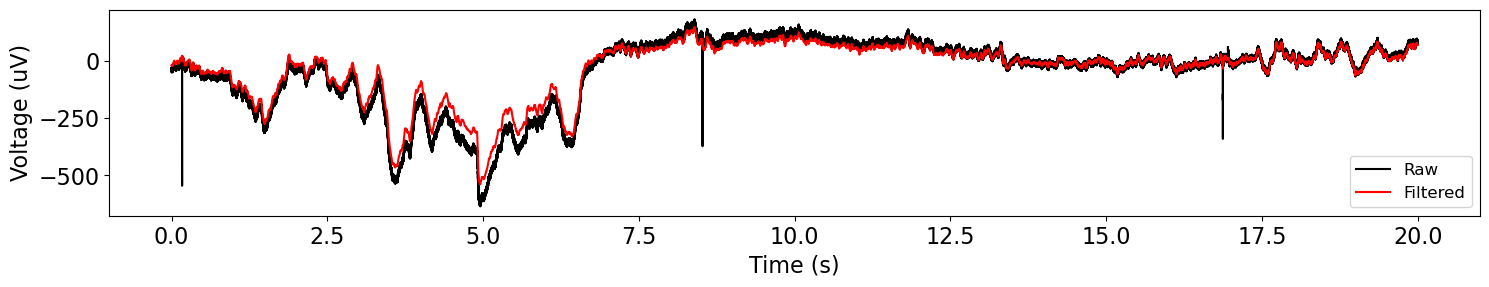

In [106]:
filter_plot(sig, sig_filt_all, fs, plot_sec=20)

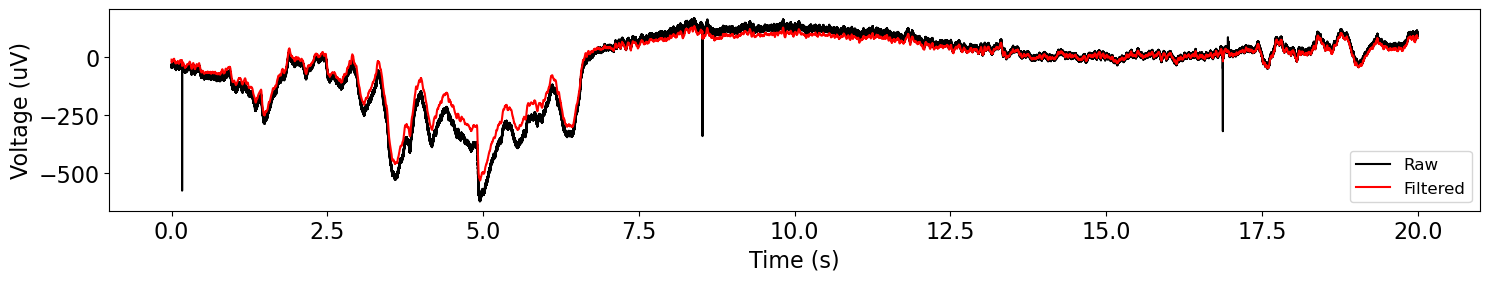

In [107]:
filter_plot(c2, c2_filt, fs, plot_sec=20)

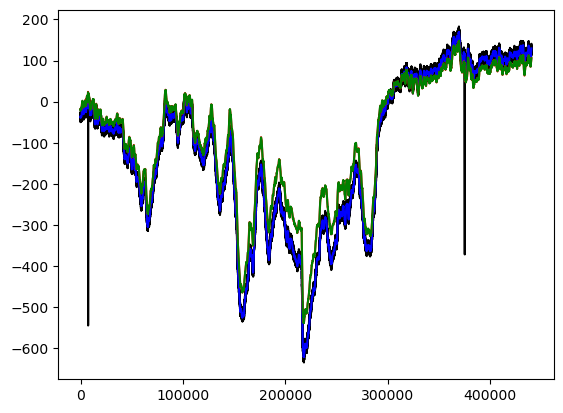

In [89]:
# visualize different filtered signals 
plt.plot(sig[:440000], color='black')
plt.plot(low_pass[:440000], color='blue')
plt.plot(high_pass[:440000], color='red')
plt.plot(sig_filt_all[:440000], color='green')

In [90]:
def downsample(lfp, hz, downsample_factor):
    '''
    Downsample signal by a factor of downsample_factor
    '''
    signal_ds = signal.decimate(lfp, downsample_factor)
    signal_hz = hz/downsample_factor
    if np.mod(hz, downsample_factor) != 0:
        raise ValueError('Sampling rate must be an integer after downsampling. Check your factor')
    return signal_ds, signal_hz

In [108]:
ds_sig, ds_hz = downsample(sig_filt_all, fs, 44)
ds_c2, ds_hz = downsample(c2_filt, fs, 44)

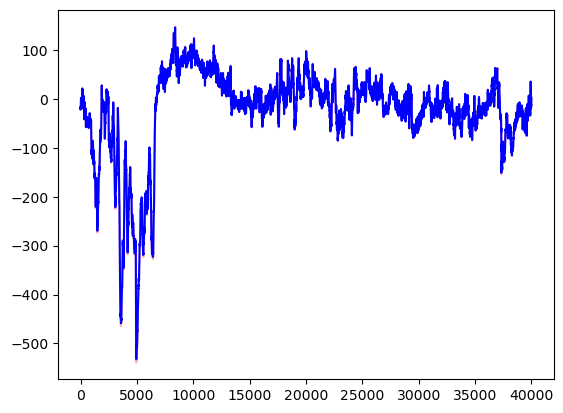

In [96]:
# visualize original and downsampled signals
plot_sec = 40
samples_ds = int(plot_sec * ds_hz)
samples_orig = int(plot_sec * fs)

ts1 = np.arange(samples_ds)
ts2 = np.linspace(0, samples_ds, samples_orig)

plt.plot(ts2, sig_filt_all[:samples_orig], 'r', alpha = 0.3)
plt.plot(ts1, ds_sig[:samples_ds], 'b')

In [109]:
# example bipolar re-referencing
ref1 = ds_sig - ds_c2

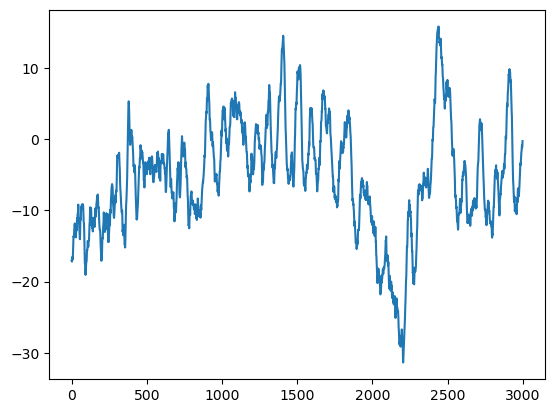

In [126]:
plt.plot(ref1[3000:6000])

In [97]:
# bipolar referencing 
ref1 = example_data['CRAW_01'] - example_data['CRAW_02']
ref2 = example_data['CRAW_01'] - example_data['CRAW_03']
ref3 = example_data['CRAW_01'] - example_data['CRAW_04']

ref4 = example_data['CMacro_RAW_03'] - example_data['CRAW_05']
ref5 = example_data['CMacro_RAW_03'] - example_data['CMacro_RAW_01']
ref6 = example_data['CMacro_RAW_03'] - example_data['CMacro_RAW_02']

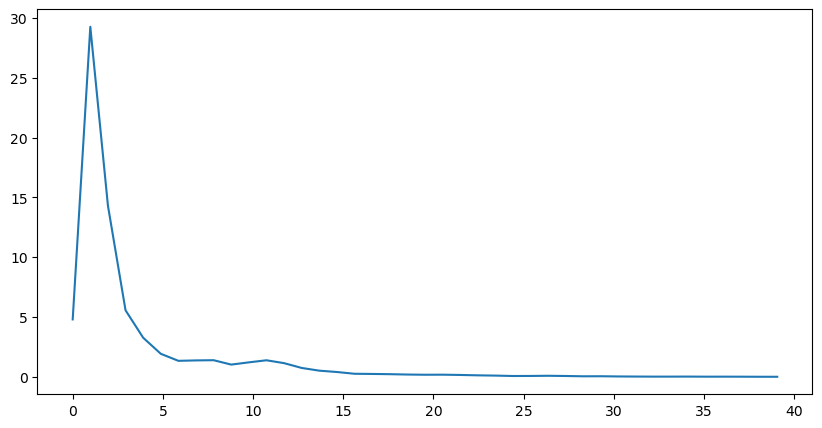

In [123]:
freq_mean1, psd_mean1 = compute_spectrum(ref1, ds_hz, method='welch', avg_type='mean', nperseg=1024)
# freq_mean2, psd_mean2 = compute_spectrum(ref1.flatten(), fs, method='welch', avg_type='mean', nperseg=1024)

new_freq1 = freq_mean1[freq_mean1<40]
new_psd1 = psd_mean1[freq_mean1<40]

# new_freq2 = freq_mean2[freq_mean2<120]
# new_psd2 = psd_mean2[freq_mean2<120]

plt.figure(figsize=(10, 5))
plt.plot(new_freq1, new_psd1, label='referenced_downsampled')
# plt.figure(figsize=(10, 5))
# plt.plot(freq_mean2, psd_mean2, label='referenced_original')
# plt.legend()

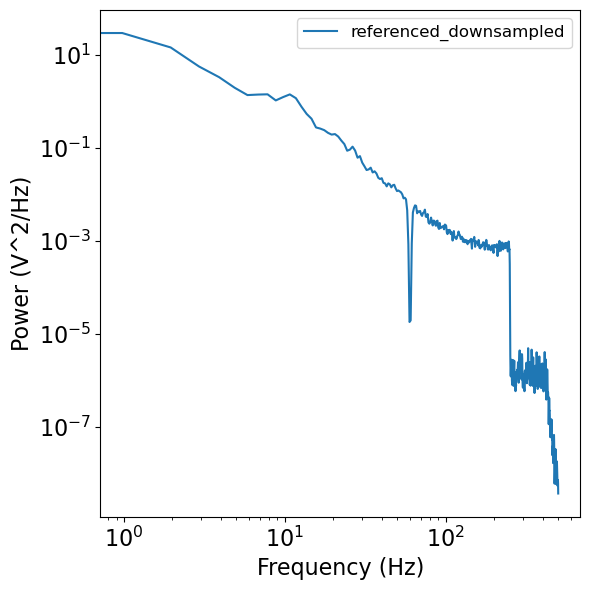

In [120]:
from neurodsp.plts.spectral import plot_power_spectra
plot_power_spectra(freq_mean1, psd_mean1, 'referenced_downsampled', log_freqs=True, log_powers=True)